In [339]:
import torch
from ray import tune
import ray
import numpy as np
import os
from pytorch_optimizer import AvaGrad 
from train import train
import pickle
from ray.train.lightning import LightningTrainer
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter


## Loading and Cleaning Metrics

In [340]:
result_grid = tune.Tuner.restore("tune_cifar10_SmallNet_no_ckpt/tune_cifar10_SmallNet", trainable=LightningTrainer).get_results()
metrics_df = result_grid.get_dataframe()
#metrics_df = pd.concat([pd.concat([result, result.metrics_dataframe], axis=1) for result in analysis], ignore_index=True)
display(metrics_df)

Failed to read the results for 1 trials:
- tune_cifar10_SmallNet_no_ckpt/tune_cifar10_SmallNet/LightningTrainer_8843f_00746_746_SAM=True,optimizer=ref_ph_6e59c6b3,lr=0.0027,weight_decay=0.0000_2023-07-02_13-56-47


,_report_on,val_loss,train_loss,epoch,step,timestamp,time_this_iter_s,should_checkpoint,done,training_iteration,...,config/lightning_config/_trainer_init_config/callbacks,config/lightning_config/_trainer_init_config/limit_train_batches,config/lightning_config/_trainer_init_config/limit_val_batches,config/lightning_config/_trainer_init_config/logger,config/lightning_config/_trainer_init_config/max_epochs,config/lightning_config/_module_init_config/config/SAM,config/lightning_config/_module_init_config/config/optimizer,config/lightning_config/_module_init_config/config/parameters/lr,config/lightning_config/_module_init_config/config/parameters/weight_decay,logdir
0,train_epoch_end,2.307307,2.303948,19,7820,1688238531,3.704602,True,False,20,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.5,1,None,20,True,<class 'torch.optim.sgd.SGD'>,1.000000,1.000000e-01,tune_cifar10_SmallNet_no_ckpt/tune_cifar10_Sma...
1,train_epoch_end,2.307106,2.303834,19,7820,1688238607,3.282485,True,False,20,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.5,1,None,20,False,<class 'torch.optim.sgd.SGD'>,1.000000,1.000000e-01,tune_cifar10_SmallNet_no_ckpt/tune_cifar10_Sma...
2,train_epoch_end,2.304007,2.302599,19,7820,1688238691,3.658920,True,False,20,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.5,1,None,20,True,<class 'pytorch_optimizer.optimizer.avagrad.Av...,1.000000,1.000000e-01,tune_cifar10_SmallNet_no_ckpt/tune_cifar10_Sma...
3,train_epoch_end,2.028016,2.096122,19,7820,1688238770,3.426250,True,False,20,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.5,1,None,20,False,<class 'pytorch_optimizer.optimizer.avagrad.Av...,1.000000,1.000000e-01,tune_cifar10_SmallNet_no_ckpt/tune_cifar10_Sma...
4,train_epoch_end,2.305197,2.302746,19,7820,1688238850,3.475510,True,False,20,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.5,1,None,20,True,<class 'torch.optim.sgd.SGD'>,0.372759,1.000000e-01,tune_cifar10_SmallNet_no_ckpt/tune_cifar10_Sma...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,train_epoch_end,1.258943,1.085192,19,7820,1688298632,4.039773,True,False,20,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.5,1,None,20,False,<class 'torch.optim.sgd.SGD'>,0.007197,1.389495e-08,tune_cifar10_SmallNet_no_ckpt/tune_cifar10_Sma...
742,train_epoch_end,1.411554,1.403883,19,7820,1688298739,5.214130,True,False,20,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.5,1,None,20,True,<class 'pytorch_optimizer.optimizer.avagrad.Av...,0.007197,1.389495e-08,tune_cifar10_SmallNet_no_ckpt/tune_cifar10_Sma...
743,train_epoch_end,1.153348,1.108285,19,7820,1688298837,4.856669,True,False,20,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.5,1,None,20,False,<class 'pytorch_optimizer.optimizer.avagrad.Av...,0.007197,1.389495e-08,tune_cifar10_SmallNet_no_ckpt/tune_cifar10_Sma...
744,train_epoch_end,2.300405,2.302069,19,7820,1688298924,3.908327,True,False,20,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.5,1,None,20,True,<class 'torch.optim.sgd.SGD'>,0.002683,1.389495e-08,tune_cifar10_SmallNet_no_ckpt/tune_cifar10_Sma...


In [341]:
metrics_df_cleaned= metrics_df.rename(columns={"config/lightning_config/_module_init_config/config/SAM":"SAM", "config/lightning_config/_module_init_config/config/optimizer":"optimizer", "config/lightning_config/_module_init_config/config/parameters/lr":"lr","config/lightning_config/_module_init_config/config/parameters/weight_decay":"weight_decay" })
metrics_df_cleaned["optimizer"] = metrics_df_cleaned["optimizer"].replace({"<class 'torch.optim.sgd.SGD'>": "SGD", "<class 'pytorch_optimizer.optimizer.avagrad.AvaGrad'>":"AvaGrad"})
metrics_df_cleaned = metrics_df_cleaned[["val_loss", "train_loss", "epoch", "lr", "weight_decay", "optimizer", "SAM", "trial_id"]]
diff_loss = pd.DataFrame(metrics_df_cleaned["val_loss"].subtract(metrics_df_cleaned["train_loss"]), columns=["diff_loss"])
metrics_df_cleaned = pd.concat([metrics_df_cleaned, diff_loss], axis=1)
display(metrics_df_cleaned.head())

,val_loss,train_loss,epoch,lr,weight_decay,optimizer,SAM,trial_id,diff_loss
0,2.307307,2.303948,19,1.000000,0.1,SGD,True,8843f_00000,0.003359
1,2.307106,2.303834,19,1.000000,0.1,SGD,False,8843f_00001,0.003272
2,2.304007,2.302599,19,1.000000,0.1,AvaGrad,True,8843f_00002,0.001408
3,2.028016,2.096122,19,1.000000,0.1,AvaGrad,False,8843f_00003,-0.068106
4,2.305197,2.302746,19,0.372759,0.1,SGD,True,8843f_00004,0.002451


## Convergence

In [342]:
def plot_all(result_grid):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    for result in result_grid:
        parameters = result.config["lightning_config"]["_module_init_config"]["config"]["parameters"]
        label = f"lr={parameters['lr']}, momentum={parameters['weight_decay']}"
        result.metrics_dataframe.plot("epoch", "train_loss", ax=ax[0], legend=False)
        result.metrics_dataframe.plot("epoch", "val_loss", ax=ax[1], legend=False)
    ax[0].set_title("Train Loss vs. Epoch for All Trials")
    ax[1].set_title("Validation Loss vs. Epoch for All Trials")
    ax[0].set_ylabel("Mean Train Loss")
    ax[1].set_ylabel("Mean Validation Loss")
#plot_all(result_grid)

## Function for creating Heatmaps

In [343]:
def plot_heatmap_2d(ax, df, title="Default Title", vmin=0, vmax=2.5):
    sns.heatmap(df, ax=ax, vmin=vmin, vmax=vmax)

    # Format x-tick labels
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels = [f'{float(label):.1e}' for label in labels]
    ax.set_xticklabels(labels)

    # Format y-tick labels
    labels = [item.get_text() for item in ax.get_yticklabels()]
    labels = [f'{float(label):.1e}' for label in labels]
    ax.set_yticklabels(labels)
    ax.set_title(title)
    plt.tight_layout()

# Results

## Train loss

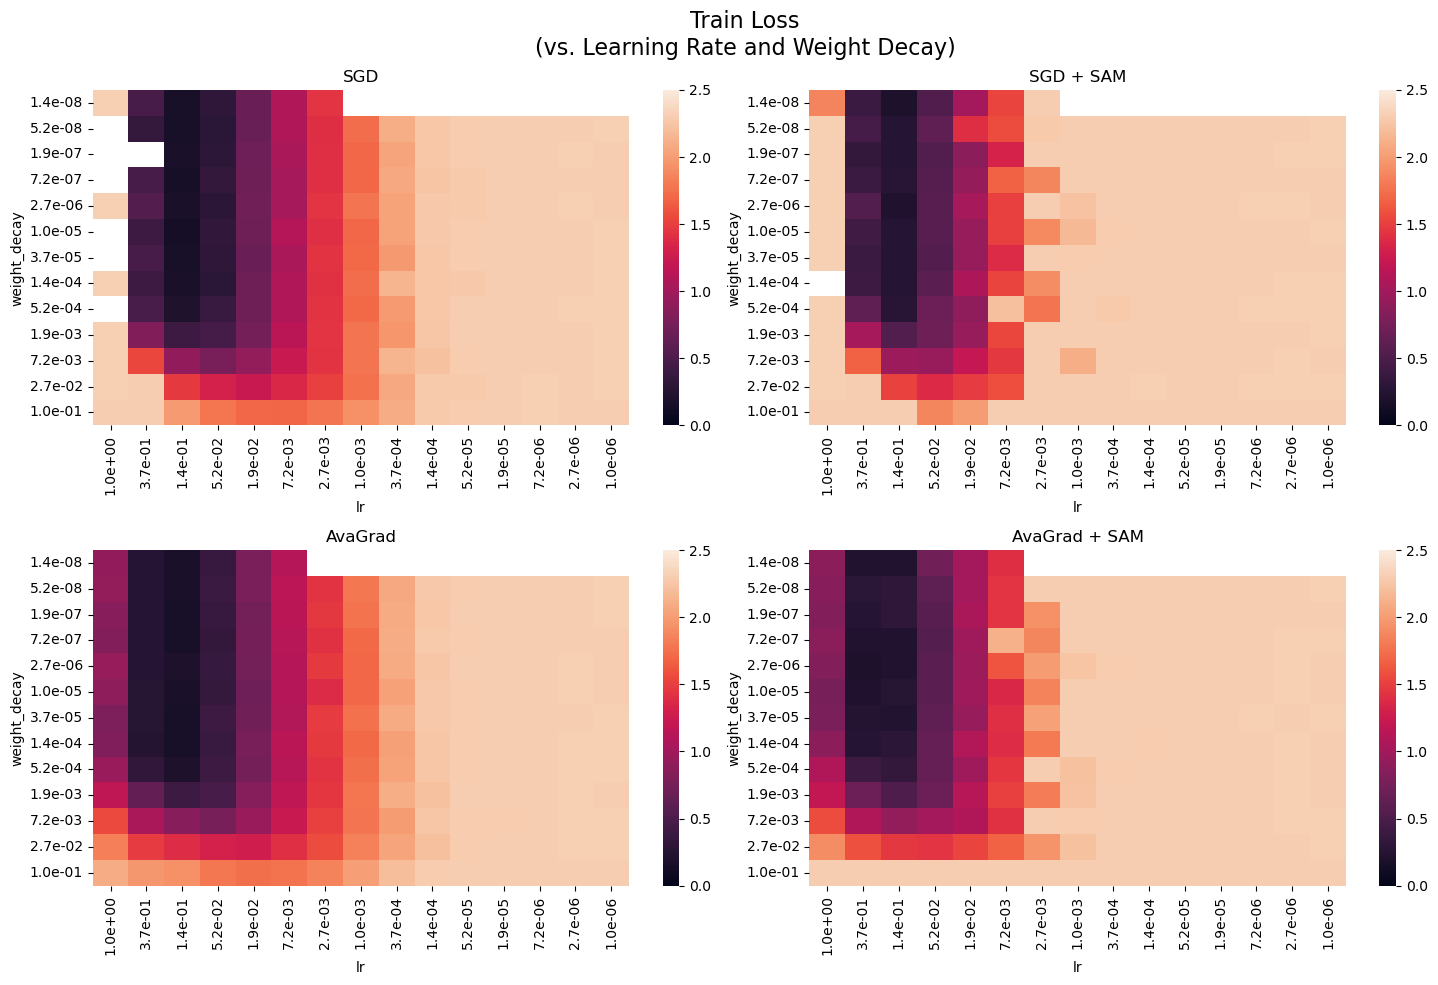

In [354]:
train_loss_sgd = metrics_df_cleaned[(metrics_df_cleaned["SAM"]==False) & (metrics_df_cleaned["optimizer"]=="SGD")].pivot(index="weight_decay", columns="lr", values="train_loss")
train_loss_sgd.sort_index(axis=1, inplace=True, ascending=False)
train_loss_avagrad = metrics_df_cleaned[(metrics_df_cleaned["SAM"]==False) & (metrics_df_cleaned["optimizer"]=="AvaGrad")].pivot(index="weight_decay", columns="lr", values="train_loss")
train_loss_avagrad.sort_index(axis=1, inplace=True, ascending=False)

train_loss_sam_sgd = metrics_df_cleaned[(metrics_df_cleaned["SAM"]==True) & (metrics_df_cleaned["optimizer"]=="SGD")].pivot(index="weight_decay", columns="lr", values="train_loss")
train_loss_sam_sgd.sort_index(axis=1, inplace=True, ascending=False)
train_loss_sam_avagrad = metrics_df_cleaned[(metrics_df_cleaned["SAM"]==True) & (metrics_df_cleaned["optimizer"]=="AvaGrad")].pivot(index="weight_decay", columns="lr", values="train_loss")
train_loss_sam_avagrad.sort_index(axis=1, inplace=True, ascending=False)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Train Loss\n(vs. Learning Rate and Weight Decay)", fontsize=16)
plot_heatmap_2d(axs[0][0], train_loss_sgd, "SGD")
plot_heatmap_2d(axs[1][0], train_loss_avagrad, "AvaGrad")
plot_heatmap_2d(axs[0][1], train_loss_sam_sgd, "SGD + SAM")
plot_heatmap_2d(axs[1][1], train_loss_sam_avagrad ,"AvaGrad + SAM")


plt.show()

## Validation loss

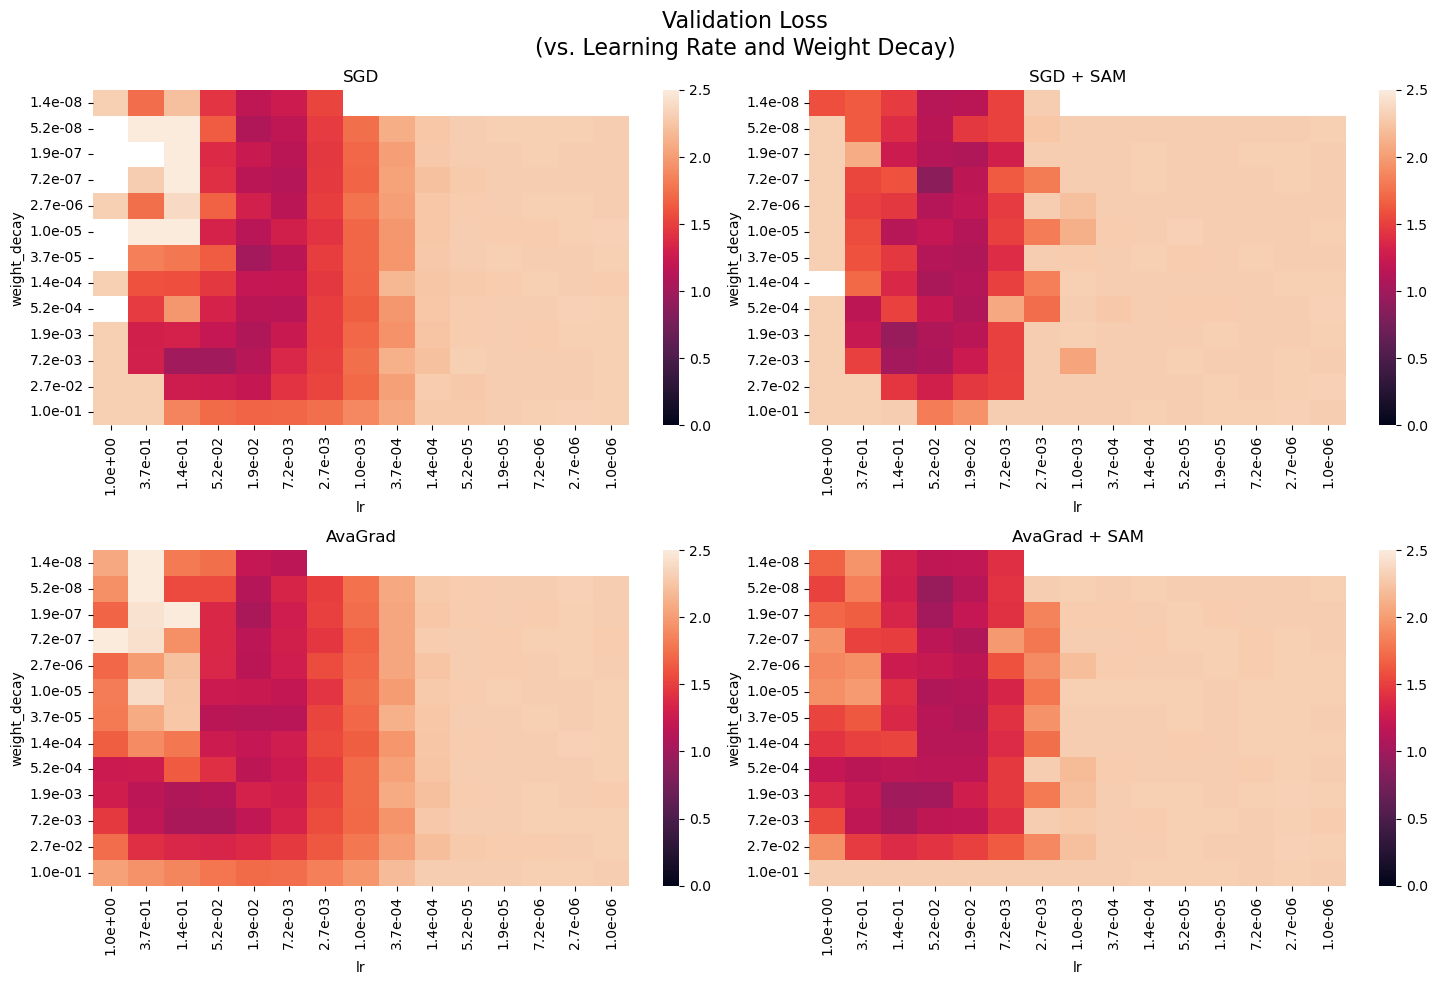

In [355]:
test_loss_sgd = metrics_df_cleaned[(metrics_df_cleaned["SAM"]==False) & (metrics_df_cleaned["optimizer"]=="SGD")].pivot(index="weight_decay", columns="lr", values="val_loss")
test_loss_sgd.sort_index(axis=1, inplace=True, ascending=False)
test_loss_avagrad = metrics_df_cleaned[(metrics_df_cleaned["SAM"]==False) & (metrics_df_cleaned["optimizer"]=="AvaGrad")].pivot(index="weight_decay", columns="lr", values="val_loss")
test_loss_avagrad.sort_index(axis=1, inplace=True, ascending=False)

test_loss_sam_sgd = metrics_df_cleaned[(metrics_df_cleaned["SAM"]==True) & (metrics_df_cleaned["optimizer"]=="SGD")].pivot(index="weight_decay", columns="lr", values="val_loss")
test_loss_sam_sgd.sort_index(axis=1, inplace=True, ascending=False)
test_loss_sam_avagrad = metrics_df_cleaned[(metrics_df_cleaned["SAM"]==True) & (metrics_df_cleaned["optimizer"]=="AvaGrad")].pivot(index="weight_decay", columns="lr", values="val_loss")
test_loss_sam_avagrad.sort_index(axis=1, inplace=True, ascending=False)


fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Validation Loss\n(vs. Learning Rate and Weight Decay)", fontsize=16)

plot_heatmap_2d(axs[0][0], test_loss_sgd, "SGD")
plot_heatmap_2d(axs[1][0], test_loss_avagrad, "AvaGrad")
plot_heatmap_2d(axs[0][1], test_loss_sam_sgd, "SGD + SAM")
plot_heatmap_2d(axs[1][1], test_loss_sam_avagrad ,"AvaGrad + SAM")
plt.show()

### Loss Difference

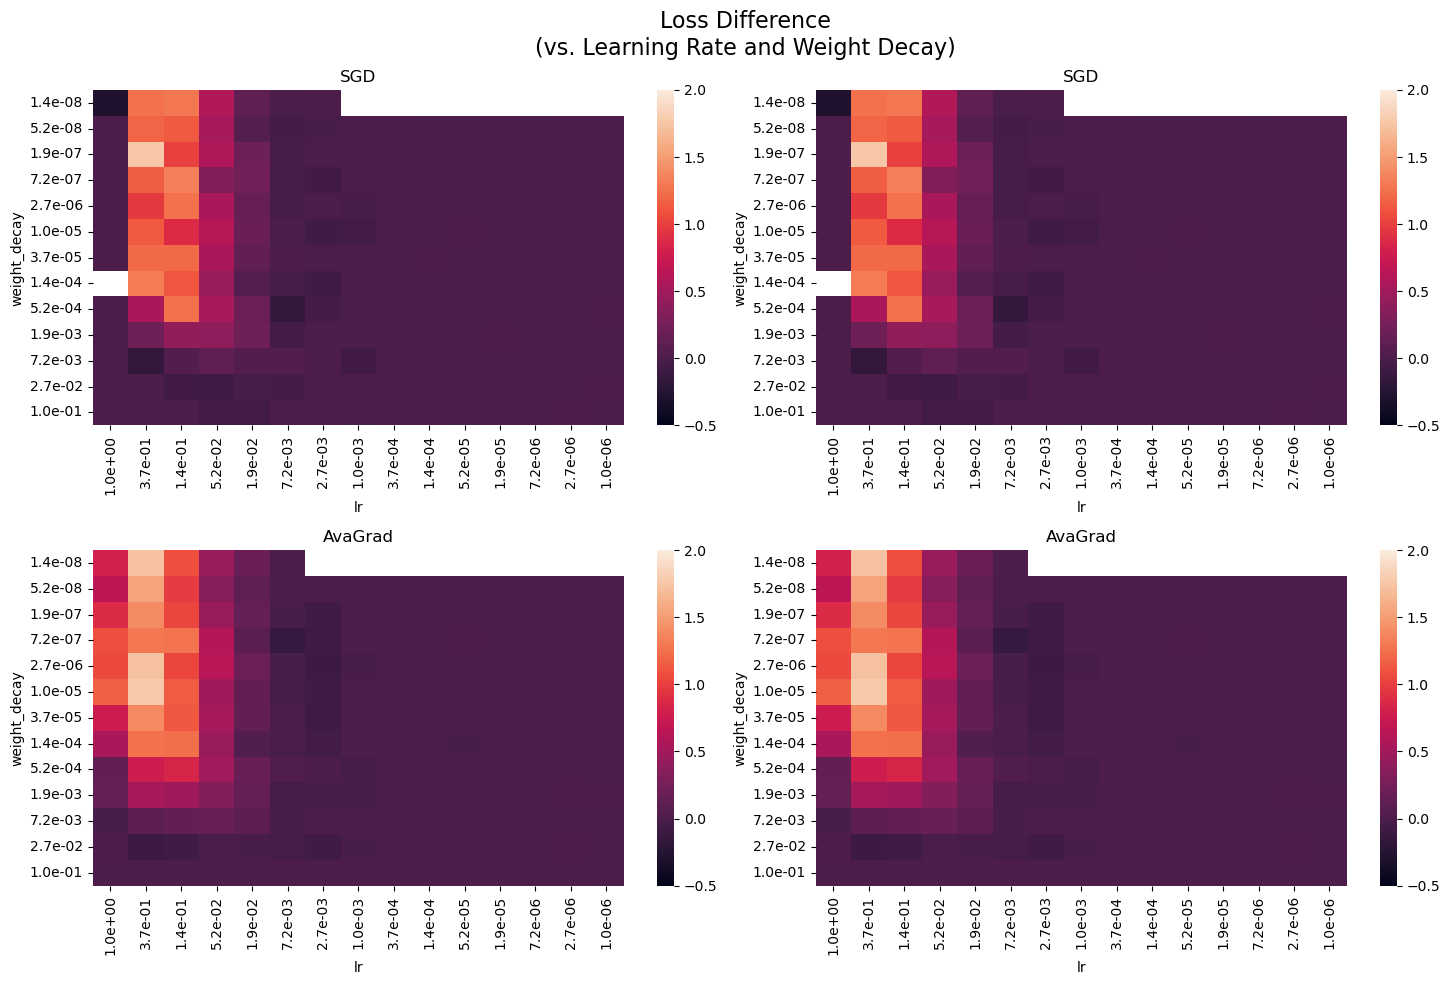

In [356]:
diff_loss_sgd = metrics_df_cleaned[(metrics_df_cleaned["SAM"]==False) & (metrics_df_cleaned["optimizer"]=="SGD")].pivot(index="weight_decay", columns="lr", values="diff_loss")
diff_loss_sgd.sort_index(axis=1, inplace=True, ascending=False)
diff_loss_avagrad = metrics_df_cleaned[(metrics_df_cleaned["SAM"]==False) & (metrics_df_cleaned["optimizer"]=="AvaGrad")].pivot(index="weight_decay", columns="lr", values="diff_loss")
diff_loss_avagrad.sort_index(axis=1, inplace=True, ascending=False)

diff_loss_sgd = metrics_df_cleaned[(metrics_df_cleaned["SAM"]==True) & (metrics_df_cleaned["optimizer"]=="SGD")].pivot(index="weight_decay", columns="lr", values="diff_loss")
diff_loss_sgd.sort_index(axis=1, inplace=True, ascending=False)
diff_loss_avagrad = metrics_df_cleaned[(metrics_df_cleaned["SAM"]==True) & (metrics_df_cleaned["optimizer"]=="AvaGrad")].pivot(index="weight_decay", columns="lr", values="diff_loss")
diff_loss_avagrad.sort_index(axis=1, inplace=True, ascending=False)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Loss Difference\n(vs. Learning Rate and Weight Decay)", fontsize=16)

plot_heatmap_2d(axs[0][0], diff_loss_sgd, "SGD", vmax=2, vmin=-0.5)
plot_heatmap_2d(axs[1][0], diff_loss_avagrad, "AvaGrad", vmax=2, vmin=-0.5)
plot_heatmap_2d(axs[0][1], diff_loss_sgd, "SGD", vmax=2, vmin=-0.5)
plot_heatmap_2d(axs[1][1], diff_loss_avagrad, "AvaGrad", vmax=2, vmin=-0.5)
plt.show()

# Lineplots comparing Validation Loss between Groups

In [347]:
display(metrics_df_cleaned)

,val_loss,train_loss,epoch,lr,weight_decay,optimizer,SAM,trial_id,diff_loss
0,2.307307,2.303948,19,1.000000,1.000000e-01,SGD,True,8843f_00000,0.003359
1,2.307106,2.303834,19,1.000000,1.000000e-01,SGD,False,8843f_00001,0.003272
2,2.304007,2.302599,19,1.000000,1.000000e-01,AvaGrad,True,8843f_00002,0.001408
3,2.028016,2.096122,19,1.000000,1.000000e-01,AvaGrad,False,8843f_00003,-0.068106
4,2.305197,2.302746,19,0.372759,1.000000e-01,SGD,True,8843f_00004,0.002451
...,...,...,...,...,...,...,...,...,...
741,1.258943,1.085192,19,0.007197,1.389495e-08,SGD,False,8843f_00741,0.173751
742,1.411554,1.403883,19,0.007197,1.389495e-08,AvaGrad,True,8843f_00742,0.007671
743,1.153348,1.108285,19,0.007197,1.389495e-08,AvaGrad,False,8843f_00743,0.045063
744,2.300405,2.302069,19,0.002683,1.389495e-08,SGD,True,8843f_00744,-0.001663


In [348]:
all_trials = pd.concat([result.metrics_dataframe for result in (result_grid)]).reset_index(drop=True)
meta_data =  metrics_df_cleaned.loc[:,["SAM", "lr", "weight_decay", "trial_id", "optimizer"]]
all_trials = all_trials.merge(meta_data, on="trial_id")
all_trials["sam_optimizer"] = "sam=" + all_trials["SAM"].astype(str) + ", optim=" + all_trials["optimizer"].astype(str)
display(all_trials.head(2))

,_report_on,val_loss,train_loss,epoch,step,timestamp,time_this_iter_s,should_checkpoint,done,training_iteration,...,pid,hostname,node_ip,time_since_restore,iterations_since_restore,SAM,lr,weight_decay,optimizer,sam_optimizer
0,train_epoch_end,2.320805,2.304928,0,391,1688238463,8.771708,True,False,1,...,1434964,idisc01-B650-AORUS-PRO-AX,134.96.247.160,8.771708,1,True,1.0,0.1,SGD,"sam=True, optim=SGD"
1,train_epoch_end,2.315571,2.304338,1,782,1688238466,3.560253,True,False,2,...,1434964,idisc01-B650-AORUS-PRO-AX,134.96.247.160,12.331961,2,True,1.0,0.1,SGD,"sam=True, optim=SGD"


In [349]:
best_trials_ids = metrics_df_cleaned.groupby(["optimizer", "SAM"])["val_loss"].idxmin()
best_trials = metrics_df_cleaned.loc[best_trials_ids].reset_index(drop=True)
display(best_trials)

,val_loss,train_loss,epoch,lr,weight_decay,optimizer,SAM,trial_id,diff_loss
0,1.047498,0.742077,19,0.019307,1.930698e-07,AvaGrad,False,8843f_00619,0.305421
1,0.948896,0.606544,19,0.051795,5.179475e-08,AvaGrad,True,8843f_00674,0.342352
2,0.999157,0.913997,19,0.138950,7.196857e-03,SGD,False,8843f_00129,0.085159
3,0.878078,0.562148,19,0.051795,7.196857e-07,SGD,True,8843f_00552,0.315931


In [350]:
best_trials_progress = all_trials[all_trials["trial_id"].isin(best_trials["trial_id"])].reset_index(drop=True)
display(best_trials_progress.head(2))

,_report_on,val_loss,train_loss,epoch,step,timestamp,time_this_iter_s,should_checkpoint,done,training_iteration,...,pid,hostname,node_ip,time_since_restore,iterations_since_restore,SAM,lr,weight_decay,optimizer,sam_optimizer
0,train_epoch_end,1.407293,1.801302,0,391,1688248738,8.084837,True,False,1,...,1664628,idisc01-B650-AORUS-PRO-AX,134.96.247.160,8.084837,1,False,0.13895,0.007197,SGD,"sam=False, optim=SGD"
1,train_epoch_end,1.277945,1.490554,1,782,1688248741,3.219258,True,False,2,...,1664628,idisc01-B650-AORUS-PRO-AX,134.96.247.160,11.304094,2,False,0.13895,0.007197,SGD,"sam=False, optim=SGD"


## Validation Loss of the Best Trials

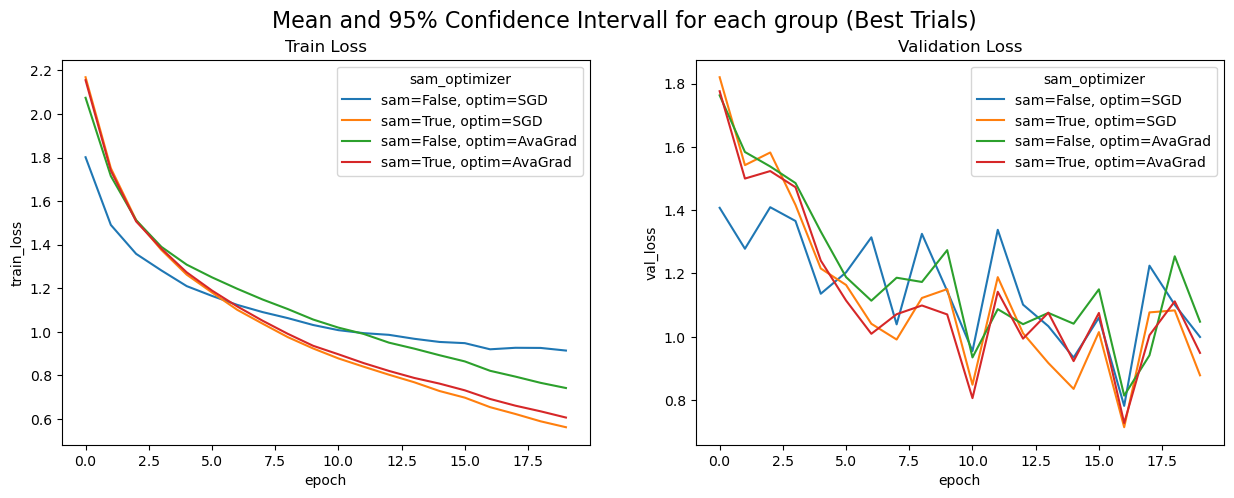

In [351]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(data=best_trials_progress, x="epoch", y="train_loss", hue="sam_optimizer", ax=ax[0]).set_title("Train Loss")
sns.lineplot(data=best_trials_progress, x="epoch", y="val_loss", hue="sam_optimizer", ax=ax[1]).set_title("Validation Loss")
fig.suptitle("Mean and 95% Confidence Intervall for each group (Best Trials)", fontsize=16)
plt.show()

## Validation Loss of All trials

### Grouped by optimizer **and** SAM

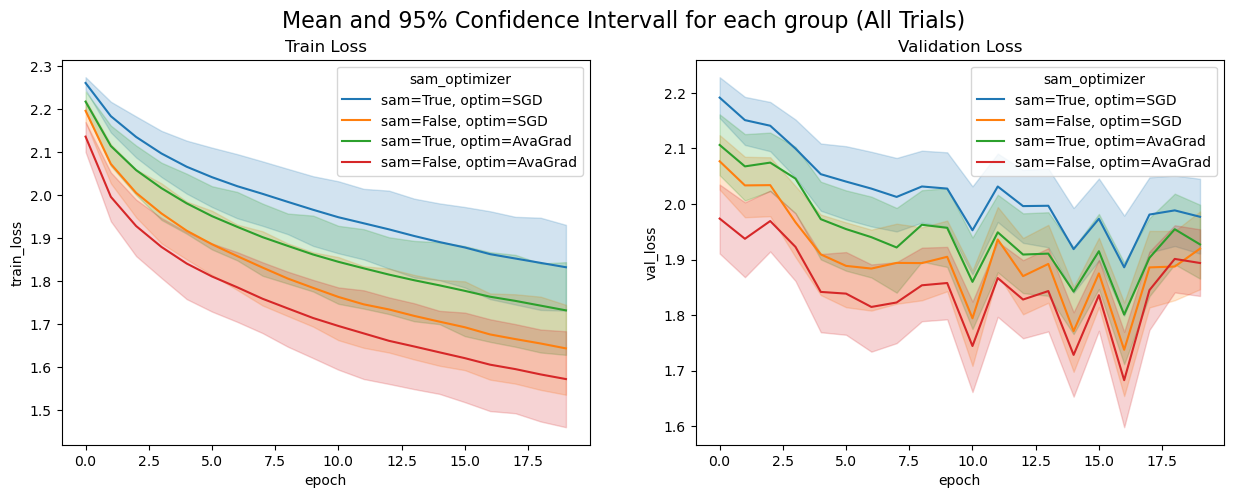

In [352]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(data=all_trials, x="epoch", y="train_loss", hue="sam_optimizer", ax=ax[0]).set_title("Train Loss")
sns.lineplot(data=all_trials, x="epoch", y="val_loss", hue="sam_optimizer", ax=ax[1]).set_title("Validation Loss")
fig.suptitle("Mean and 95% Confidence Intervall for each group (All Trials)", fontsize=16)
plt.show()

### Grouped by optimizer **or** SAM

Text(0.5, 1.0, 'Validation Loss')

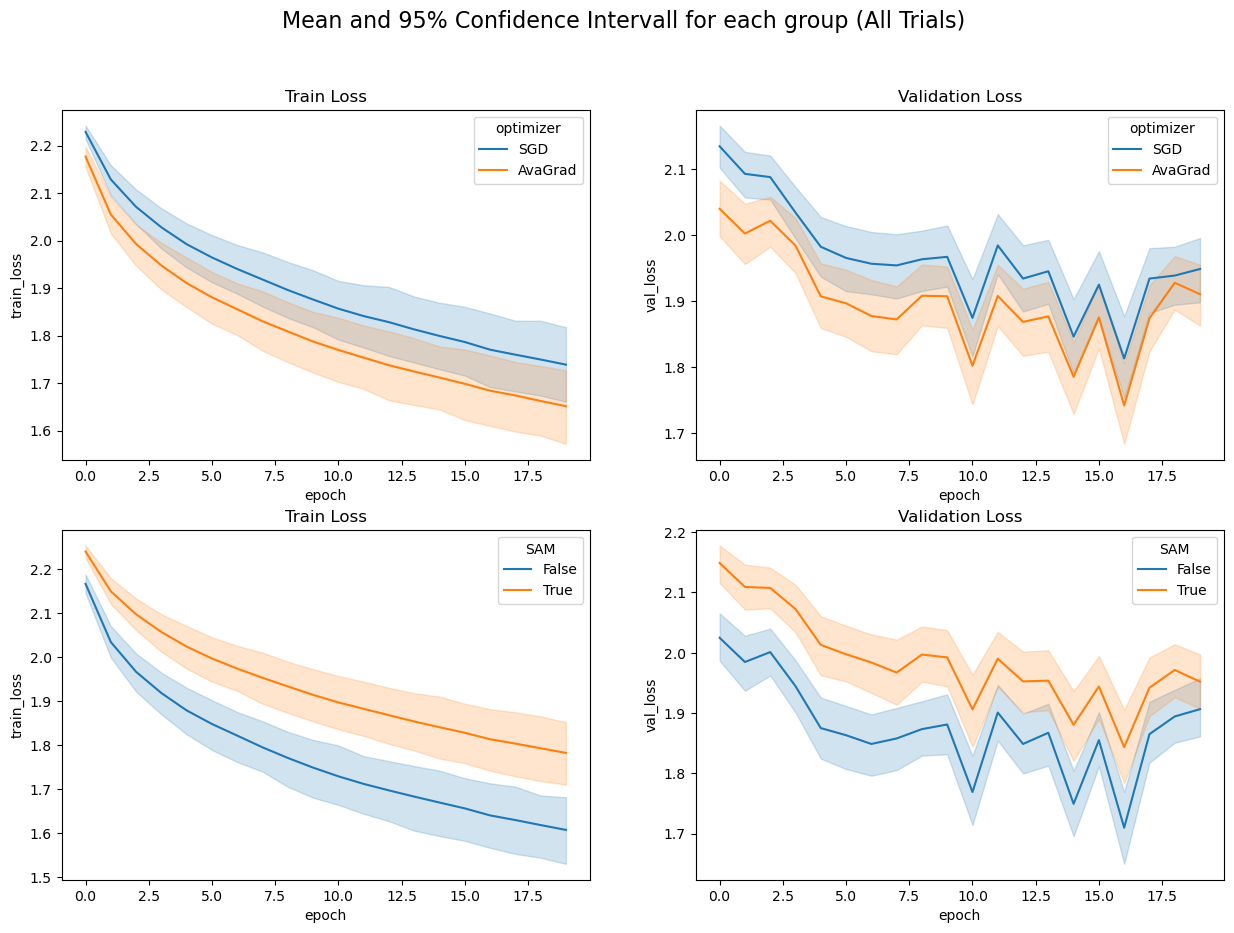

In [353]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Mean and 95% Confidence Intervall for each group (All Trials)", fontsize=16)
sns.lineplot(data=all_trials, x="epoch", y="train_loss", hue="optimizer", ax=ax[0][0]).set_title("Train Loss")
sns.lineplot(data=all_trials, x="epoch", y="val_loss", hue="optimizer", ax=ax[0][1]).set_title("Validation Loss")
sns.lineplot(data=all_trials, x="epoch", y="train_loss", hue="SAM", ax=ax[1][0]).set_title("Train Loss")
sns.lineplot(data=all_trials, x="epoch", y="val_loss", hue="SAM", ax=ax[1][1]).set_title("Validation Loss")
#ax[0][0].set_title("Validation Loss of All Trials\n(Mean and 95% Confidence Intervall for each group)")
#ax[1].set_title("Validation Loss of All Trials\n(Mean and 95% Confidence Intervall for each group)")